# Import Packages and Data

In [1]:
# Import Packages
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
# import matplotlib.pyplot as plt

# Classification Model
# import xgboost as xgb
from sklearn.model_selection import train_test_split #, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

# Post Analysis
from sklearn.manifold import TSNE


# Custom functions
# BERT model embeddings
from src.model_operations import get_embeddings, write_target_descriptive_categories
# Custom Model diagnostics
from src.model_diagnostics import categorical_accuracy_table, confusion_matrix

In [2]:
# Variables

#============#
# Data
#============#
filepath = "data/"
filename = "downsampled_dataset.csv"

OUTPUT_FILEPATH = "data/"
OUTPUT_FILENAME = 'KNN_Classifier_Results.csv'


#============#
# Modeling Params
#============#
test_size = .25


In [3]:
# Import Data
data = pd.read_csv(str(filepath)+str(filename))

data.head()

,ID,TITLE,URL,PUBLISHER,CATEGORY,STORY,HOSTNAME,TIMESTAMP
0,295933,HBO's 'Game of Thrones' Finale Draws 7.1 Milli...,http://variety.com/2014/tv/ratings/hbos-game-o...,Variety,1,dC3-DM8Lb3vGU5Mkhf3DSUhxreGDM,variety.com,1403015867587
1,120908,Yahoo shares surge after first quarter revenue...,http://www.bizjournals.com/sanjose/news/2014/0...,Silicon Valley Business Journal,2,dT_6B-49u7PCtGMmH5Z4F4aMi-tKM,www.bizjournals.com,1397641368477
2,95402,UPDATE 2-Hotel chain La Quinta makes subdued d...,http://www.reuters.com/article/2014/04/09/laqu...,Reuters,2,d2cfi33G40EuaaMxFzMxeeXjzFgvM,www.reuters.com,1397065266477
3,234064,Major Study Finds E-Cigarettes Great for Quitt...,http://www.highlightpress.com/major-study-find...,Highlight Press,4,dUsqYpuEIbZlGfMjE1lyduks_WBVM,www.highlightpress.com,1400709444772
4,305499,The Most Important Features In Amazon's New Fi...,http://www.seattlepi.com/technology/businessin...,seattlepi.com,2,du-1bLu6hjI-CbM2f51YYbHc8JZGM,www.seattlepi.com,1403187295257


# Modeling

Data Preparation for Modeling

In [4]:
# Create modeling df using only the columns you need

df = pd.DataFrame()
# Independent variables
df['Text'] = data['TITLE']
# Dependent variable
df['CATEGORY'] = data['CATEGORY']

Encode Target variable

In [5]:
def clean_target(value):
    if value == 'e':
        return 0
    elif value == 'b':
        return 1
    elif value == 't':
        return 2
    elif value == 'm':
        return 3
    else:
        return "ERROR"
        # return 1
    
df['Target'] = df['CATEGORY'].apply(clean_target)

Train/Test split data for modeling

In [6]:
# Train,Test Split
train_titles, test_titles, y_train, y_test = train_test_split(df['Text'], df['CATEGORY'], test_size=test_size, random_state=123)

# Check distribution of dependent variable in train and test
print("Train Value Counts")
print(y_train.value_counts())
print("Test Value Counts")
print(y_test.value_counts())

Train Value Counts
CATEGORY
3    22693
2    16931
4    12184
1    11555
Name: count, dtype: int64
Test Value Counts
CATEGORY
3    7531
2    5735
4    3933
1    3922
Name: count, dtype: int64


# Embed Text

In [7]:
# Use SentenceBERT model to embed text
X_train = get_embeddings(train_titles.tolist())
X_test = get_embeddings(test_titles.tolist())

# Train Model

In [8]:
# Create a k-NN classifier with 6 neighbors
knn = KNeighborsClassifier(n_neighbors=15)
# Fit the classifier to the data
knn.fit(X_train, y_train)

# results DF
results = pd.DataFrame()
# Add predictions to test dataset
results['Prediction'] = knn.predict(X_test)
# Add ground truth
results['Target'] = y_test.values

# Training dataset
training = pd.DataFrame()
training['Target'] = y_train
training['Predictions'] = knn.predict(X_train)

# Model Diagnostics

Check Results

In [9]:
# Plot global model accuracy metrics
# print("Training Dataset")
# categorical_accuracy_table(training['Target'], training['Predictions'])
print("Test Dataset")
categorical_accuracy_table(results['Target'],results['Prediction'])

Test Dataset


,Measure,Value
0,Accuracy,0.941954
1,F1_Score,0.941901
2,Precision,0.941915
3,Recall,0.941954
4,MCC,0.920457


Test Dataset


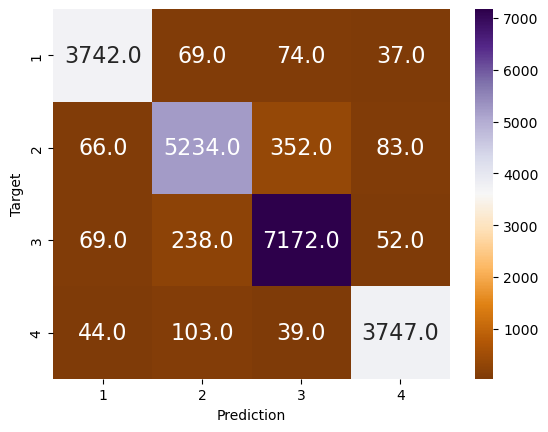

In [10]:
# # Plot confusion matrix
# print("Training Dataset")
# confusion_matrix(training['Target'], training['Predictions'])
print("Test Dataset")
confusion_matrix(results['Target'],results['Prediction'])

# Post-Modeling Visualization

Dimentionality Reduction

In [11]:
# Create tsne object
tsne = TSNE(n_components=2)

# Fit tsne to test data
X_test_embedded = TSNE(n_components=2).fit_transform(X_test)

# Clean up data
test_df_embeddings = pd.DataFrame(X_test_embedded)
test_df_embeddings = test_df_embeddings.rename(columns={0:'x',1:'y'})
test_df_embeddings['Prediction'] = knn.predict(X_test)

Data Preparation for Visuals

In [12]:
# Additional Metadata Columns for visuals
## Record when models prediction matches ground truth
results['Hits'] = np.where(results['Target']==results['Prediction'], 1, 0)


## Create columns for visual's legend
results['Hits Labeled'] = np.where(results['Target']==results['Prediction'], 'Correct Predictions', 'Incorrect Predictions')

In [13]:
# Create visualization dataset
## Copy tsne df
visualization_dataset = test_df_embeddings
## Reset index
visualization_dataset.reset_index(inplace=True, drop=True)
## Merge tsne results with results df
visualization_dataset = pd.merge(visualization_dataset, results, how='inner', left_index=True, right_index=True)
## Clean up columns
visualization_dataset = visualization_dataset.drop(columns=['Prediction_x'])
visualization_dataset = visualization_dataset.rename(columns={'Prediction_y':'Prediction', 'Target_y':'Target', "Hits_y":"Hits"})

# Check results
visualization_dataset.tail()

,x,y,Prediction,Target,Hits,Hits Labeled,Descriptive Category Label
21116,14.458590,-57.599285,3,3,1,Correct Predictions,Science/Technology
21117,-30.548191,-0.532891,1,1,1,Correct Predictions,Entertainment
21118,-42.524384,-92.097511,4,4,1,Correct Predictions,Health
21119,61.643158,67.832443,3,3,1,Correct Predictions,Science/Technology
21120,-6.113155,55.198147,3,3,1,Correct Predictions,Science/Technology


# Output Model Results

In [14]:
# Output visualization dataset
visualization_dataset.to_csv(str(OUTPUT_FILEPATH)+str(OUTPUT_FILENAME), sep=',', index = False)